## Импорт бибилиотек

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import bootstrap

import scipy.stats as ss
import plotly.express as px
from scipy.stats import chi2_contingency, chi2 

## Чтение данных

In [65]:
users_data = pd.read_csv('ab_users_data.csv')
products = pd.read_csv('ab_products.csv')
orders = pd.read_csv('ab_orders.csv')

In [66]:
users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [67]:
products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [68]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


## Исследование данных

In [69]:
print(users_data.isna().sum())
print(products.isna().sum())
print(orders.isna().sum())

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64
product_id    0
name          0
price         0
dtype: int64
order_id         0
creation_time    0
product_ids      0
dtype: int64


Пропусков в данных нет

In [70]:
users_data.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [71]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [72]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

## Преобразование данных

In [73]:
users_data.time = pd.to_datetime(users_data.time)
users_data.date = pd.to_datetime(users_data.date)
users_data.dtypes

user_id              int64
order_id             int64
action              object
time        datetime64[ns]
date        datetime64[ns]
group                int64
dtype: object

In [74]:
orders.creation_time = pd.to_datetime(orders.creation_time)
orders.dtypes

order_id                  int64
creation_time    datetime64[ns]
product_ids              object
dtype: object

Привела даты к нужному типу

Теперь соединим таблицы

In [75]:
orders['product_id'] = orders['product_ids'].astype(str).str.strip('{}').str.replace(' ', '').str.split(',')


In [76]:
orders = orders.explode('product_id')

In [77]:
orders

,order_id,creation_time,product_ids,product_id
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",75
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",22
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",53
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",84
1,1256,2022-08-26 00:02:21,"{56, 76, 39}",56
...,...,...,...,...
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}",9
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}",62
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}",77
4122,59533,2022-09-08 23:41:24,"{17, 85}",17


In [78]:
orders['product_id'] = orders['product_id'].astype('int64')

Разложили списки продуктов на отдельные строки. Теперь добавим к ним цены

In [79]:
prod_price = orders.merge(products, on='product_id')[['order_id', 'product_id', 'price']]
prod_price

,order_id,product_id,price
0,1255,75,120.0
1,1287,75,120.0
2,1403,75,120.0
3,1424,75,120.0
4,1495,75,120.0
...,...,...,...
13821,33910,11,200.0
13822,34742,11,200.0
13823,41998,11,200.0
13824,53851,11,200.0


И к этим данным добавим еще данные пользователей

In [80]:
users_prod_price = prod_price.merge(users_data, on='order_id')
users_prod_price

,order_id,product_id,price,user_id,action,time,date,group
0,1255,75,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
1,1255,22,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
2,1255,53,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0
3,1255,84,90.4,964,create_order,2022-08-26 00:00:19,2022-08-26,0
4,1287,75,120.0,987,create_order,2022-08-26 00:31:36,2022-08-26,0
...,...,...,...,...,...,...,...,...
14564,25283,82,30.4,1247,create_order,2022-09-02 15:27:56,2022-09-02,1
14565,41639,82,30.4,1657,create_order,2022-09-05 08:54:56,2022-09-05,1
14566,57283,82,30.4,1829,create_order,2022-09-08 16:06:17,2022-09-08,1
14567,57283,11,200.0,1829,create_order,2022-09-08 16:06:17,2022-09-08,1


Строк получилось больше, потому что дублируются заказы, которые были отменены

## Выбор метрик

Тут я вижу несколько вариантов метрик. Например:

- количество заказов на одного пользователя
- количество товаров на каждый заказ
- сумма потраченная одним пользователем
- различия между группами по количеству отмененных заказов

Посмотрим на каждую метрику отдельно

### 1. Количество заказов на одного пользователя

In [81]:
users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


Создадим новый признак, по которому будем считать в дальнейшем

In [82]:
users_data['orders'] = users_data.action.apply(lambda x: 1 if x == 'create_order' else -1)

Теперь отмененные заказы будут автоматом отниматься при сложении. Поскольку Все отмененные заказы имеют 2 статуса - создание и отмена, то в результате сложения будут выдавать 0 и не будут учитываться в общей сумме заказов


Теперь посчитаем нашу метрику (количество заказов на одного пользователя), сгруппировав данные по пользователям

In [83]:
results = users_data.groupby(['user_id', 'group'], as_index=False)\
.agg({'orders':'sum'})
results

,user_id,group,orders
0,964,0,2
1,965,1,9
2,966,0,0
3,967,1,5
4,968,0,3
...,...,...,...
1012,1976,1,5
1013,1977,1,4
1014,1978,1,6
1015,1979,1,5


Сравним визуально данные

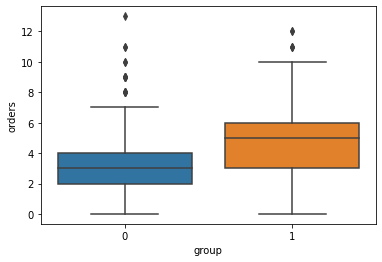

In [84]:
sns.boxplot(x= 'group', y= 'orders', data = results)

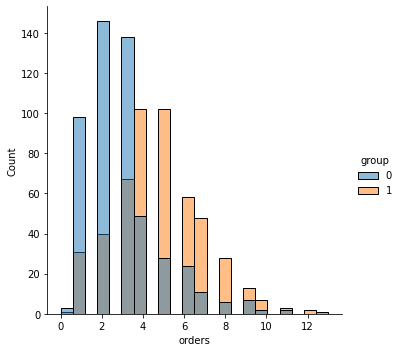

In [85]:
sns.displot(data=results, x="orders", hue="group")

Теперь проверим распределение на нормалность

In [86]:
ss.normaltest(results.query('group == 0').orders)

NormaltestResult(statistic=176.03905799091814, pvalue=5.937508680322359e-39)

In [87]:
ss.normaltest(results.query('group == 1').orders)

NormaltestResult(statistic=16.28882316460579, pvalue=0.00029035345049441036)

Значения в обеих группах распределены ненормально

In [88]:
results.groupby('group').agg({'orders': np.median})

,orders
group,
0,3
1,5


Медианы отличаются

In [89]:
results.groupby('group').agg({'orders': np.mean})

,orders
group,
0,2.965049
1,4.745020


Средние тоже

Для выбора теста у нас 1 переменная и 2 независимые категории. Согласно таблицы, выбор падает на тест Манна-Уитни
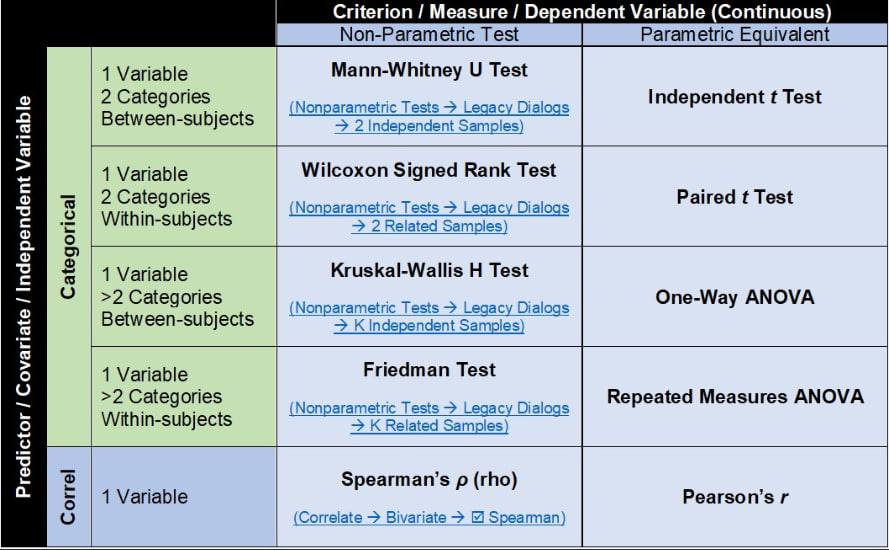

In [90]:
mannwhitneyu(results.query('group == 0').orders, results.query('group == 1').orders)

MannwhitneyuResult(statistic=63507.0, pvalue=8.932329495353261e-46)

Тест показывает р-значение меньше 0.05, p-value < 0.05 - значит, нулевая гипотеза о том, что различий нет, отклоняется. Принимается альтернативная о том, что различия есть.

#### По метрике "количество доставок на 1 пользователя" различия есть и тестовая группа показала лучший результат

### 2. Kоличество товаров на каждый заказ

In [91]:
users_prod_price.head(3)

,order_id,product_id,price,user_id,action,time,date,group
0,1255,75,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
1,1255,22,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
2,1255,53,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0


Также как и с количеством заказов сделаем столбец, где будут учитываться отмененные заказы

In [92]:
users_prod_price['orders'] = users_prod_price.action.apply(lambda x: 1 if x == 'create_order' else -1)
users_prod_price

,order_id,product_id,price,user_id,action,time,date,group,orders
0,1255,75,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
1,1255,22,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
2,1255,53,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
3,1255,84,90.4,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
4,1287,75,120.0,987,create_order,2022-08-26 00:31:36,2022-08-26,0,1
...,...,...,...,...,...,...,...,...,...
14564,25283,82,30.4,1247,create_order,2022-09-02 15:27:56,2022-09-02,1,1
14565,41639,82,30.4,1657,create_order,2022-09-05 08:54:56,2022-09-05,1,1
14566,57283,82,30.4,1829,create_order,2022-09-08 16:06:17,2022-09-08,1,1
14567,57283,11,200.0,1829,create_order,2022-09-08 16:06:17,2022-09-08,1,1


Сгруппируем данные по заказм и посчитаем сколько продуктов в каждом заказе

In [93]:
prod_per_order = users_prod_price.groupby(['order_id', 'group'], as_index=False)\
.agg({'orders':'sum'})
prod_per_order

,order_id,group,orders
0,1255,0,4
1,1256,1,3
2,1257,0,4
3,1258,0,0
4,1259,1,4
...,...,...,...
4118,59422,1,3
4119,59439,1,5
4120,59464,0,3
4121,59487,0,3


Теперь визуализируем сравнение данных по группам

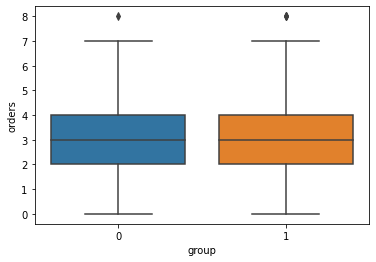

In [94]:
sns.boxplot(x= 'group', y= 'orders', data = prod_per_order)

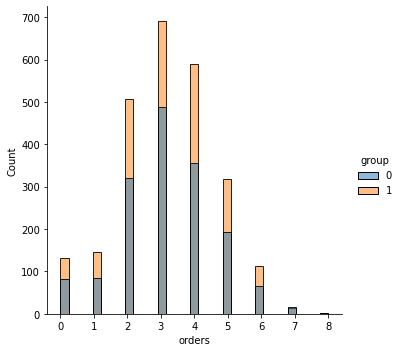

In [95]:
sns.displot(data=prod_per_order, x="orders", hue="group")

Визуально данные не отличаются. Проверим это статичстическими методами. Для начала посмотрим на нормальность распределения

In [96]:
ss.normaltest(prod_per_order.query('group == 0').orders)

NormaltestResult(statistic=0.3290514812716935, pvalue=0.8482959209869125)

In [97]:
ss.normaltest(prod_per_order.query('group == 1').orders)

NormaltestResult(statistic=3.945653355545696, pvalue=0.1390632132323555)

Значения в обеих группах распределены нормально

Посмотрим основные показатели

In [98]:
prod_per_order.groupby('group').agg({'orders': np.median})

,orders
group,
0,3
1,3


In [99]:
prod_per_order.groupby('group').agg({'orders': np.mean})

,orders
group,
0,3.171535
1,3.174224


Средние и медианы не отличаются. 

Выборки у нас независимы. Следующий шаг - проверить равность дисперсий

In [100]:
ss.levene(prod_per_order.query('group == 0').orders, prod_per_order.query('group == 1').orders)

LeveneResult(statistic=1.655515220087463, pvalue=0.19828221206908547)

Дисперсии в группах равно - применяем Т-критерий Стьюдента

In [101]:
ss.ttest_ind(prod_per_order.query('group == 0').orders, prod_per_order.query('group == 1').orders)

Ttest_indResult(statistic=-0.057858589029637586, pvalue=0.9538640741531343)

Тест показывает р-значение больше 0.05 - значит, нулевая гипотеза о том, что различий нет, принимается.

#### По метрике "количество товаров на 1 заказ" различий между тестовой и контрольной группой нет 

### 3. Cумма потраченная одним пользователем

Тут придется взять отдельный срез датасета, который не будет содержать отмененные заказы

In [102]:
users_prod_price_pos = users_prod_price[~users_prod_price['order_id']
                                  .isin(users_prod_price[users_prod_price['action'] == 'cancel_order']['order_id'])]
users_prod_price_pos

,order_id,product_id,price,user_id,action,time,date,group,orders
0,1255,75,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
1,1255,22,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
2,1255,53,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
3,1255,84,90.4,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
4,1287,75,120.0,987,create_order,2022-08-26 00:31:36,2022-08-26,0,1
...,...,...,...,...,...,...,...,...,...
14564,25283,82,30.4,1247,create_order,2022-09-02 15:27:56,2022-09-02,1,1
14565,41639,82,30.4,1657,create_order,2022-09-05 08:54:56,2022-09-05,1,1
14566,57283,82,30.4,1829,create_order,2022-09-08 16:06:17,2022-09-08,1,1
14567,57283,11,200.0,1829,create_order,2022-09-08 16:06:17,2022-09-08,1,1


In [103]:
sum_per_user = users_prod_price_pos.groupby(['user_id', 'group'], as_index=False)\
.agg({'price':'sum'})
sum_per_user

,user_id,group,price
0,964,0,718.9
1,965,1,4155.5
2,967,1,1137.4
3,968,0,1590.7
4,969,0,681.9
...,...,...,...
1008,1976,1,2001.9
1009,1977,1,781.2
1010,1978,1,2276.3
1011,1979,1,1907.1


Теперь у нас есть две группы пользователей с суммами потраченных в целом. Посмотрим основные показатели

In [104]:
sum_per_user.groupby('group').agg({'price': np.median})

,price
group,
0,955.7
1,1630.1


In [105]:
sum_per_user.groupby('group').agg({'price': np.mean})

,price
group,
0,1139.562305
1,1753.749301


Визуализируем данные

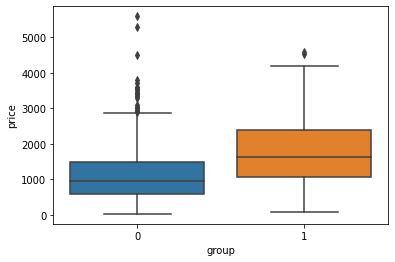

In [106]:
sns.boxplot(x= 'group', y= 'price', data = sum_per_user)

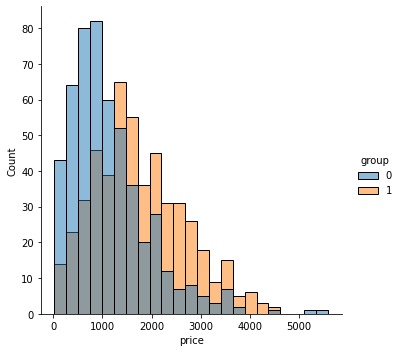

In [107]:
sns.displot(data=sum_per_user, x="price", hue="group")

Визуально данные отличаются. Проверим это статистическими тестами. Сначала тест на нормальность распределения

In [108]:
ss.normaltest(sum_per_user.query('group == 0').price)

NormaltestResult(statistic=165.14145937540584, pvalue=1.3803452652449226e-36)

In [109]:
ss.normaltest(sum_per_user.query('group == 1').price)

NormaltestResult(statistic=21.243033778154764, pvalue=2.438562133100675e-05)

Значения в обеих группах распределены ненормально

Для выбора теста у нас 1 переменная и 2 независимые категории. Согласно таблицы, выбор падает на тест Манна-Уитни

In [110]:
mannwhitneyu(sum_per_user.query('group == 0').price, sum_per_user.query('group == 1').price)

MannwhitneyuResult(statistic=75129.5, pvalue=3.683322098282286e-30)

Тест показывает р-значение меньше 0.05, p-value < 0.05 - значит, нулевая гипотеза о том, что различий нет, отклоняется. Принимается альтернативная о том, что различия есть.

#### По метрике "сумма затрат на 1 пользователя" различия есть и тестовая группа показала лучший результат

### 4.Различия между группами по количеству отмененных заказов

In [111]:
users_prod_price.head(3)

,order_id,product_id,price,user_id,action,time,date,group,orders
0,1255,75,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
1,1255,22,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1
2,1255,53,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0,1


In [112]:
pd.crosstab(users_prod_price.action, users_prod_price.group)

group,0,1
action,,
cancel_order,287,456
create_order,5390,8436


In [113]:
fig = px.histogram(users_prod_price[['group', 'action']].dropna(), x='group', 
                   color='action')
fig.show()

In [114]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_prod_price.action, users_prod_price.group))
print('p-value: ', p)
print('Stat: ', stat)

p-value:  0.876066215194651
Stat:  0.024322862938880578


In [115]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


#### По метрике **различия между группами по количеству отмененных заказов** принимаем нулевую гипотезу о том, значимых различий нет